In [0]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib           
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

#Connections between Canadian Provinces
A = torch.tensor([[1,     1,     1,     0,     0,     0,     0,     0,     1,     0,     1,     1,     1],
                  [1,     1,     1,     0,     0,     1,     0,     0,     1,     0,     1,     1,     0],
                  [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
                  [0,     0,     0,     1,     1,     0,     0,     0,     1,     1,     1,     0,     0],
                  [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [0,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
                  [0,     0,     0,     0,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [0,     0,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
                  [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
                  [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
                  [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
                  [1,     0,     0,     0,     0,     1,     0,     1,     1,     0,     1,     0,     1]]);

#Number of connections each province has                  
L = torch.tensor([[6,    -1,    -1,     0,     0,     0,     0,     0,    -1,     0,    -1,    -1,    -1], 
                  [-1,    6,    -1,     0,     0,    -1,     0,     0,    -1,     0,    -1,    -1,     0],
                  [-1,    1,     7,     0,     0,    -1,     0,    -1,    -1,     0,    -1,    -1,     0],
                  [0,     0,     0,     4,    -1,     0,     0,     0,    -1,    -1,    -1,     0,     0],
                  [0,     0,     0,    -1,     5,     0,    -1,     0,    -1,    -1,    -1,     0,     0],
                  [0,    -1,    -1,     0,     0,     7,     0,    -1,    -1,     0,    -1,    -1,    -1],
                  [0,     0,     0,     0,    -1,     0,     4,     0,    -1,    -1,    -1,     0,     0],
                  [0,     0,    -1,     0,     0,    -1,     0,     6,    -1,     0,    -1,    -1,    -1],
                  [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    12,    -1,    -1,    -1,   -1],
                  [0,     0,     0,    -1,    -1,     0,    -1,     0,    -1,     5,    -1,     0,     0],
                  [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    12,    -1,   -1],
                  [-1,    -1,    -1,     0,     0,    -1,     0,    -1,    -1,     0,    -1,     7,    0],
                  [-1,     0,     0,     0,     0,    -1,     0,    -1,    -1,     0,    -1,     0,    5]]);

In [0]:
def SEImodel(theta,S,E,I):
    alpha = theta[0]
    beta  = theta[1]
    gamma = theta[2]
    mu    = theta[3]
    kE    = theta[4]
    kS    = theta[5]
    kI    = theta[6]
    

    dSdt  = -kS*L[n,n]*S - beta*E*S - gamma*I*S                 # dS/dt
    dEdt  = -kE*L[n,n]*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    dIdt  = -kI*L[n,n]*I + alpha*E - mu*I                       # dI/dt
    
    return dSdt, dEdt, dIdt

In [0]:
def integrateSEI(theta,S0,E0,I0,dt,nt):
    
    # vectors to save the results over time
    Sout = torch.zeros(nt+1); Sout[0] = S0
    Eout = torch.zeros(nt+1); Eout[0] = E0
    Iout = torch.zeros(nt+1); Iout[0] = I0
    
    S = S0; E = E0; I = I0
    for i in range(nt):
        dSdt, dEdt, dIdt = SEImodel(theta,S,E,I)
 

        S += dt*dSdt
        E += dt*dEdt
        I += dt*dIdt

        Sout[i+1] = S
        Eout[i+1] = E
        Iout[i+1] = I
       
    if I >= 0.05:
      print(S,E,I)
      return Sout, Eout, Iout
       
    return Sout, Eout, Iout

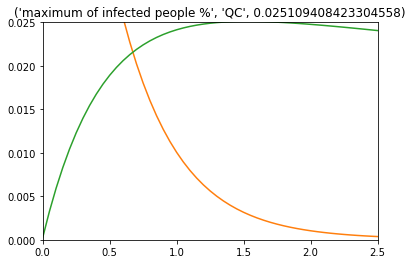

In [49]:
#QB Data as of MARCH 29 2020
PopulationQB = 521542   #WorldPopulationView
Recovered = 4         #Deceased -> it is impossible to tell if people who have recovered have returned to being infected
Infected = 135 - Recovered    #https://www.ctvnews.ca/health/coronavirus/tracking-every-case-of-covid-19-in-canada-1.4852102
Succeptible = PopulationQB - Infected
#max infected people in NL is 131/52154=0.000251, or 0.0251% of NL population

#March 28 has highest amount of new infected (curve continues to spike), no sign of flattening rip
#https://www.ctvnews.ca/health/coronavirus/tracking-every-case-of-covid-19-in-canada-1.4852102

S0 = Succeptible/PopulationQB 
E0 = 0.1
I0 = Infected/PopulationQB

# Set the duration for the simulation
dt = 0.05; nt = 50
xmin = 0; xmax = 2.5
ymin = 0; ymax = 0.025

# We pick the parameters as follows
alpha = 0.6       #rate of exposed people that get sick
beta  = 0.3       #rate of interaction of exposed and susceptible
gamma = 0.1       #rate of interaction infected and susceptible

mu    = 0.015       #rate of pepole who get resistence or die

kE    = 0.3       #Exposed people that move around
kS    = 0.16       #Susceptible people that move around
kI    = 0.01     #Sick people that move around (Diffusion of sick people)
theta = torch.tensor([alpha, beta, gamma, mu, kE, kS, kI])


P = ['AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']
for n in range(1):

  S, E, I = integrateSEI(theta,S0,E0,I0,dt,nt)

  t = np.arange(nt+1)*dt
  title = 'maximum of infected people %', P[10], torch.max(I).item()
  plt.figure(10)
  plt.title(title)
  plt.plot(t,S,t,E,t,I)
  axes = plt.gca()
  axes.set_xlim([xmin,xmax])
  axes.set_ylim([ymin,ymax])

  #NOTE: max infected people in NL is 131/52154=0.000251, or 0.0251% of NL population